# Lasso Model Selection: AIC-BIC / cross-validation

[Resource](https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html#sphx-glr-auto-examples-linear-model-plot-lasso-model-selection-py)

This example focuses on model selection for Lasso models that are linear models with an L1 penalty for regression problems.

Indeed, several strategies can be used to select the value of the regularization parameter: via cross-validation or using an information criterion, namely AIC or BIC.

In what follows, we will discuss in details the different strategies.

In [1]:
from sklearn.datasets import load_diabetes

X, y = load_diabetes(return_X_y=True, as_frame=True)
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


We'll also add some random features to the original data to better illustrate the feature selection performed by the Lasso model.

In [ ]:
import numpy as np
import pandas as pd

rng = np.random.RandomState(42)
n_random_features = 14
X_random = pd.DataFrame(
    rng.randn(X.shape[0], n_random_features),
    columns=[f"random_{i:02d}" for i in range(n_random_features)],
)
X = pd.concat([X, X_random], axis=1)
X[X.columns[::3]].head() # Every 3rd column

,age,bp,s3,s6,random_02,random_05,random_08,random_11
0,0.038076,0.021872,-0.043401,-0.017646,0.647689,-0.234137,-0.469474,-0.465730
1,-0.001882,-0.026328,0.074412,-0.092204,-1.012831,-1.412304,0.067528,0.110923
2,0.085299,-0.005670,-0.032356,-0.025930,-0.601707,-1.057711,0.208864,0.196861
3,-0.089063,-0.036656,-0.036038,-0.009362,-1.478522,1.057122,0.324084,0.611676
4,0.005383,0.021872,0.008142,-0.046641,0.331263,-0.185659,0.812526,1.003533


# Selecting Lasso via an information criterion

`LassoLarsIC` provides a Lasso estimator that uses AIC or the BIC to select the optimal value of the regularization parameter alphs.

Before fitting the model, we will standardize the data with a `StandardScaler`. In addition, we will measure the time to fit and tun the hyperparameter alpha in order to compare with the cross-validation strategy.

We will first fit a Lasso model with the AIC criterion.

In [5]:
import time

from sklearn.linear_model import LassoLarsIC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

start_time = time.time()
lasso_lars_ic = make_pipeline(StandardScaler(), LassoLarsIC(criterion="aic")).fit(X, y)
fit_time = time.time() - start_time

We store the AIC metric for each value of alpha used during `fit`.

In [6]:
results = pd.DataFrame(
    {
        "alphas": lasso_lars_ic[-1].alphas_,
        "AIC criterion": lasso_lars_ic[-1].criterion_,
    }
).set_index("alphas")
alpha_aic = lasso_lars_ic[-1].alpha_

Now, we perform the same analysis using the BIC criterion.

In [8]:
lasso_lars_ic.set_params(lassolarsic__criterion="bic").fit(X, y)
results["BIC criterion"] = lasso_lars_ic[-1].criterion_
alpha_bic = lasso_lars_ic[-1].alpha_

We can check which value of `alpha` leads to the minimum AIC and BIC.

In [10]:
def highlight_min(x):
    x_min = x.min()
    return ["font-weight: bold" if v == x_min else "" for v in x]

results.style.apply(highlight_min)

,AIC criterion,BIC criterion
alphas,,
45.160030,5244.764779,5244.764779
42.300343,5208.250639,5212.341949
21.542052,4928.018900,4936.201520
15.034077,4869.678359,4881.952289
6.189631,4815.437362,4831.802601
5.329616,4810.423641,4830.880191
4.306012,4803.573491,4828.121351
4.124225,4804.126502,4832.765671
3.820705,4803.621645,4836.352124


Finally, we can plot the AIC and BIC values for the different alpha values. The vertical lines in the plot correspond to the alpha chosen for each criterion. The selected alpha corresponds to the minimum of the AIC or BIC criterion.

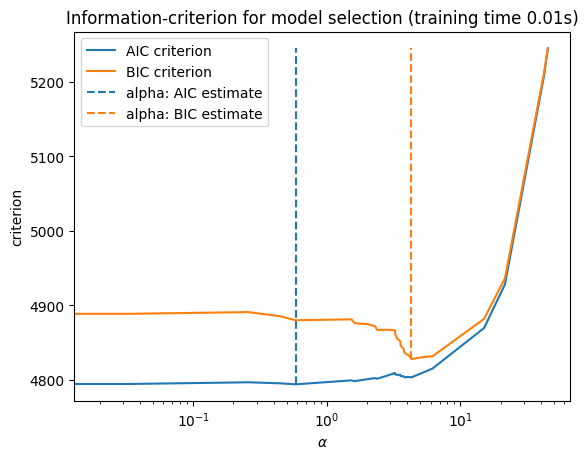

In [11]:
ax = results.plot()
ax.vlines(
    alpha_aic,
    results["AIC criterion"].min(),
    results["AIC criterion"].max(),
    label="alpha: AIC estimate",
    linestyles="--",
    color="tab:blue",
)
ax.vlines(
    alpha_bic,
    results["BIC criterion"].min(),
    results["BIC criterion"].max(),
    label="alpha: BIC estimate",
    linestyle="--",
    color="tab:orange",
)
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel("criterion")
ax.set_xscale("log")
ax.legend()
_ = ax.set_title(
    f"Information-criterion for model selection (training time {fit_time:.2f}s)"
)

Model selection with an information-criterion is very fast. It relies on computing the criterion on the in-sample set provided to fit. Both criteria estimate the model generalization error based on the training set error and penalize this overly optimistic error. However, this penalty relies on a proper estimation of the degrees of freedom and the noise variance. Both are derived for large samples (asymptotic results) and assume the model is correct, i.e. that the data are actually generated by this model.

These models also tend to break when the problem is badly conditioned (more features than samples). It is then required to provide an estimate of the noise variance.